In [56]:
import warnings
warnings.filterwarnings('ignore')


In [57]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load the dataset
data_path = 'Divorce-Wolfers-AER.dta'
divorce_data = pd.read_stata(data_path)

divorce_data


,st,year,div_rate,stpop,lfdivlaw,unilateral,years_unilateral,years_unilateral_long,reform,evdiv50,...,brinigbuckley,nakonezny,gruber_yrs,friedberg_yrs,johnson_yrs,mechoulan_yrs,ellmanlohr1_yrs,ellmanlohr2_yrs,brinigbuckley_yrs,nakonezny_yrs
0,AK,1956.0,2.700000,224000,1935.0,1.0,15.0,21.0,1.0,0.226420,...,0.0,1962.0,>=15 years,No change in sample,No change in sample,No change in sample,No change in sample,>=15 years,No change in sample,No change in sample
1,AK,1957.0,2.400000,231000,1935.0,1.0,15.0,23.0,1.0,0.226420,...,0.0,1962.0,>=15 years,No change in sample,No change in sample,No change in sample,No change in sample,>=15 years,No change in sample,No change in sample
2,AK,1958.0,2.500000,224000,1935.0,1.0,15.0,23.0,1.0,0.226420,...,0.0,1962.0,>=15 years,No change in sample,No change in sample,No change in sample,No change in sample,>=15 years,No change in sample,No change in sample
3,AK,1959.0,3.000000,224000,1935.0,1.0,15.0,25.0,1.0,0.226420,...,0.0,1962.0,>=15 years,No change in sample,No change in sample,No change in sample,No change in sample,>=15 years,No change in sample,No change in sample
4,AK,1960.0,3.500000,229000,1935.0,1.0,15.0,25.0,1.0,0.226420,...,0.0,1962.0,>=15 years,No change in sample,No change in sample,No change in sample,No change in sample,>=15 years,No change in sample,No change in sample
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2188,WY,1994.0,6.452876,474982,1977.0,1.0,15.0,17.0,1.0,0.087421,...,0.0,1977.0,>=15 years,>=15 years,>=15 years,>=15 years,>=15 years,>=15 years,No change in sample,>=15 years
2189,WY,1995.0,6.688306,478447,1977.0,1.0,15.0,19.0,1.0,0.087421,...,0.0,1977.0,>=15 years,>=15 years,>=15 years,>=15 years,>=15 years,>=15 years,No change in sample,>=15 years
2190,WY,1996.0,6.457190,480085,1977.0,1.0,15.0,19.0,1.0,0.087421,...,0.0,1977.0,>=15 years,>=15 years,>=15 years,>=15 years,>=15 years,>=15 years,No change in sample,>=15 years
2191,WY,1997.0,6.185017,480031,1977.0,1.0,15.0,21.0,1.0,0.087421,...,0.0,1977.0,>=15 years,>=15 years,>=15 years,>=15 years,>=15 years,>=15 years,No change in sample,>=15 years


In [58]:
divorce_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2193 entries, 0 to 2192
Data columns (total 48 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   st                     2193 non-null   object  
 1   year                   2193 non-null   float32 
 2   div_rate               2102 non-null   float32 
 3   stpop                  2193 non-null   int32   
 4   lfdivlaw               2193 non-null   float32 
 5   unilateral             2193 non-null   float32 
 6   years_unilateral       2193 non-null   float32 
 7   years_unilateral_long  2193 non-null   float32 
 8   reform                 2193 non-null   float32 
 9   evdiv50                2193 non-null   float32 
 10  married                204 non-null    float32 
 11  married_annual         2193 non-null   float64 
 12  neighper               2193 non-null   float32 
 13  time                   2193 non-null   float32 
 14  timesq                 2193 non-null   f

In [59]:
# Prepare the data by setting up dummy variables for fixed effects
divorce_data['state_fe'] = pd.Categorical(divorce_data['st'])
divorce_data['year_fe'] = pd.Categorical(divorce_data['year'])

Tab 1

In [60]:
filtered_data = divorce_data.dropna(subset=['div_rate'])
weights_filtered = filtered_data['stpop']
filtered_data['year_code'] = filtered_data['year'].astype(int) - filtered_data['year'].min()
filtered_data['state_code'] = pd.Categorical(filtered_data['st']).codes

# Linear and quadratic trends
filtered_data['state_time'] = filtered_data['state_code'] * filtered_data['year_code']
filtered_data['state_time_sq'] = filtered_data['state_time'] ** 2

# Weighted OLS with interaction terms for linear and quadratic trends
# Basic model with state and year fixed effects
model_basic_weighted_ = smf.wls('div_rate ~ unilateral + C(state_fe) + C(year_fe)', 
                                         data=filtered_data, weights=weights_filtered)
results_basic_weighted_ = model_basic_weighted_.fit()

# Model with linear trends
model_linear_trends_weighted_ = smf.wls('div_rate ~ unilateral + C(state_fe) + C(year_fe) + state_time', 
                                                 data=filtered_data, weights=weights_filtered)
results_linear_trends_weighted_ = model_linear_trends_weighted_.fit()

# Model with quadratic trends
model_quadratic_trends_weighted_ = smf.wls('div_rate ~ unilateral + C(state_fe) + C(year_fe) + state_time + state_time_sq', 
                                                    data=filtered_data, weights=weights_filtered)
results_quadratic_trends_weighted_ = model_quadratic_trends_weighted_.fit()

# Collect  results for Table 1
table_1_results_weighted__new = pd.DataFrame({
    "Specification": ["Basic Weighted ", "Linear Trends Weighted ", "Quadratic Trends Weighted "],
    "Unilateral Coef": [results_basic_weighted_.params['unilateral'], 
                        results_linear_trends_weighted_.params['unilateral'], 
                        results_quadratic_trends_weighted_.params['unilateral']],
    "Unilateral SE": [results_basic_weighted_.bse['unilateral'], 
                      results_linear_trends_weighted_.bse['unilateral'], 
                      results_quadratic_trends_weighted_.bse['unilateral']],
    "Adjusted R-squared": [results_basic_weighted_.rsquared_adj, 
                           results_linear_trends_weighted_.rsquared_adj, 
                           results_quadratic_trends_weighted_.rsquared_adj]
})

table_1_results_weighted__new


,Specification,Unilateral Coef,Unilateral SE,Adjusted R-squared
0,Basic Weighted,-0.215871,0.052616,0.894260
1,Linear Trends Weighted,-0.134467,0.055465,0.895244
2,Quadratic Trends Weighted,-0.150298,0.057036,0.895266


Tab 2
i did the same thing as the paper but in every year while he did it for  one year. i thught f taking the mean but it didnt make much sense to me

In [61]:

for i in range(1, 16):
    filtered_data.drop(f'unilateral_{i}', axis=1, inplace=True, errors='ignore')

# create interaction terms for years since unilateral divorce laws correctly
for i in range(1, 16):
    filtered_data[f'unilateral_{i}'] = ((filtered_data['years_unilateral'] == i).astype(int) * filtered_data['unilateral']).astype(int)

# include the interaction terms appropriately
dynamic_terms = ' + '.join([f'unilateral_{i}' for i in range(1, 16)])
formula_dynamic = f'div_rate ~ {dynamic_terms} + C(state_fe) + C(year_fe)'
formula_dynamic_linear = f'div_rate ~ {dynamic_terms} + C(state_fe) + C(year_fe)+ state_time + state_time_sq'
formula_dynamic_quadratic = f'div_rate ~ {dynamic_terms} + C(state_fe) + C(year_fe)+ state_time '
# Weighted regression model 
model_dynamic = smf.wls(formula_dynamic, data=filtered_data, weights=weights_filtered)
model_dynamic_linear = smf.wls(formula_dynamic_linear, data=filtered_data, weights=weights_filtered)
model_dynamic_quadratic = smf.wls(formula_dynamic_quadratic, data=filtered_data, weights=weights_filtered)

results_dynamic = model_dynamic.fit()
results_dynamic_linear = model_dynamic_linear.fit()
results_dynamic_quadratic = model_dynamic_quadratic.fit()

# Collect results for Table 2 with dynamic effects and interaction terms
dynamic_effects = {
    "Period since Unilateral": [f"Year {i}" for i in range(1, 16)],
    "Coefficient": results_dynamic.params.filter(regex='unilateral_').tolist(),
    "Standard Error": results_dynamic.bse.filter(regex='unilateral_').tolist(),
}

table_2_results = pd.DataFrame(dynamic_effects)
table_2_results


,Period since Unilateral,Coefficient,Standard Error
0,Year 1,2.737744e-01,9.609401e-02
1,Year 2,9.155594e-17,2.817539e-17
2,Year 3,2.226143e-01,9.646730e-02
3,Year 4,6.889977e-17,1.295934e-17
4,Year 5,1.801715e-01,9.545460e-02
5,Year 6,1.987153e-17,1.417157e-17
6,Year 7,1.785121e-01,9.478544e-02
7,Year 8,-8.849879e-17,1.256582e-17
8,Year 9,-9.549654e-02,9.417335e-02
9,Year 10,0.000000e+00,0.000000e+00


Fig 1 & 3
Fig 1 seems right , for fig 3 thats the closest i could get but coldnt fix the x-axis which is the years since the refrm 

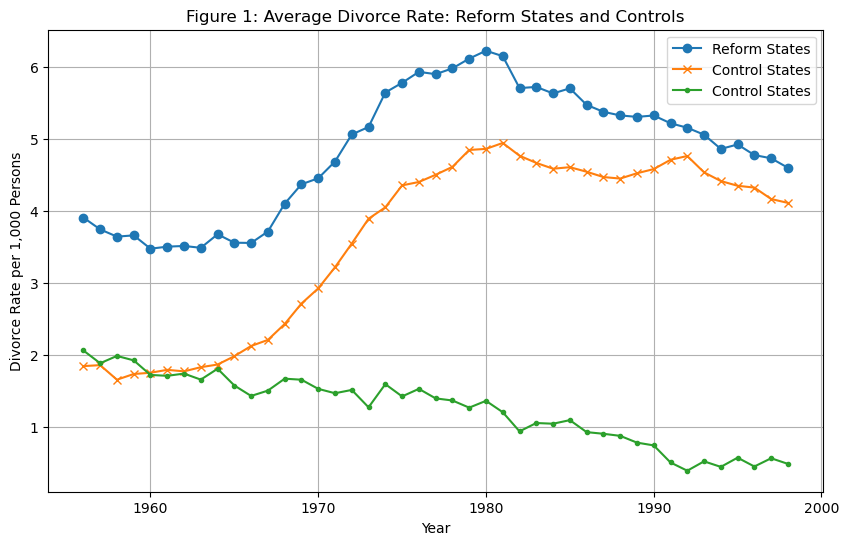

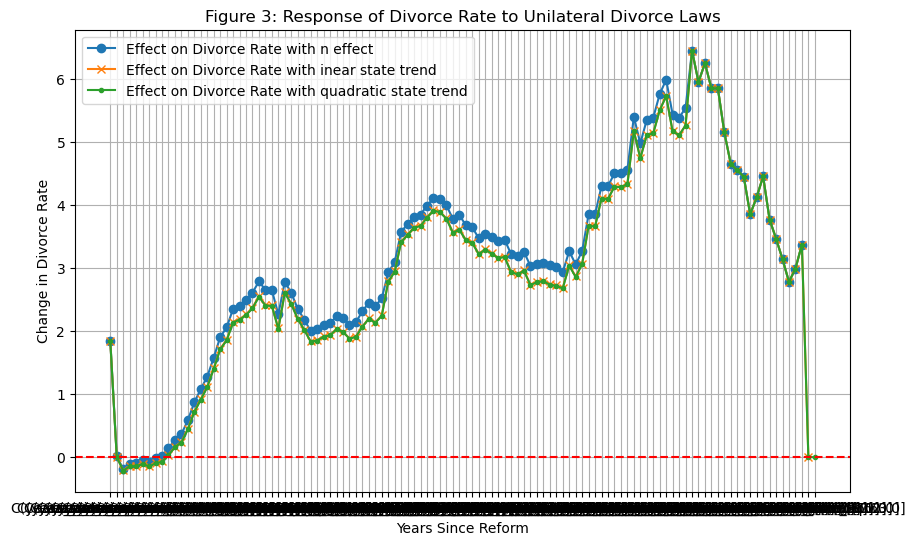

In [62]:
import matplotlib.pyplot as plt


# Create Figure 1: Average Divorce Rate across reform and control states
reform_states = divorce_data[divorce_data['reform'] == 1]
control_states = divorce_data[divorce_data['reform'] == 0]

# Group by year and calculate mean divorce rates
reform_grouped = reform_states.groupby('year')['div_rate'].mean()
control_grouped = control_states.groupby('year')['div_rate'].mean()
diff = reform_grouped.values - control_grouped.values

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(reform_grouped.index, reform_grouped.values, label='Reform States', marker='o')
plt.plot(control_grouped.index, control_grouped.values, label='Control States', marker='x')
plt.plot(control_grouped.index, diff, label='Control States', marker='.')

plt.title('Figure 1: Average Divorce Rate: Reform States and Controls')
plt.xlabel('Year')
plt.ylabel('Divorce Rate per 1,000 Persons')
plt.legend()
plt.grid(True)
plt.show()

# Prepare to create Figure 3: Dynamic response of divorce rate to unilateral divorce laws
filtered_data['years_since_reform'] = filtered_data['year'] - filtered_data['lfdivlaw']
model_response = smf.ols('div_rate ~ C(years_since_reform)', data=filtered_data).fit()
model_response_inear = smf.ols('div_rate ~ C(years_since_reform) + state_time ', data=filtered_data).fit()
model_response_quadratic = smf.ols('div_rate ~ C(years_since_reform) + state_time + state_time_sq', data=filtered_data).fit()



response_coeffs = model_response.params 
response_coeffs_inear = model_response_inear.params 
response_coeffs_quadratic = model_response_quadratic.params

plt.figure(figsize=(10, 6))
plt.plot(response_coeffs.index, response_coeffs.values, label='Effect on Divorce Rate with n effect', marker='o')
plt.plot(response_coeffs_inear.index, response_coeffs_inear.values, label='Effect on Divorce Rate with inear state trend', marker='x')
plt.plot(response_coeffs_quadratic.index, response_coeffs_quadratic.values, label='Effect on Divorce Rate with quadratic state trend', marker='.')

plt.title('Figure 3: Response of Divorce Rate to Unilateral Divorce Laws')
plt.xlabel('Years Since Reform')
plt.ylabel('Change in Divorce Rate')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()


